# Data Extraction via API

In [108]:
from cryptocompare.blockchain_data import get_blockchain_data
from cryptocompare.ohlcv import get_ohlcv
import pandas as pd
import ta
from ta.volatility import AverageTrueRange
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.volume import OnBalanceVolumeIndicator
from ta.volume import AccDistIndexIndicator

fsyms = ['ETH', 'BTC', 'DOGE', 'MATIC']

# Collect data
ohlcv_data = pd.DataFrame()
blockchain_data = pd.DataFrame()

for fsym in fsyms:
    ohlcv_data_temp = get_ohlcv(fsym)
    ohlcv_data_temp['symbol'] = fsym
    ohlcv_data = pd.concat([ohlcv_data, ohlcv_data_temp])

    blockchain_data_temp = get_blockchain_data(fsym)
    blockchain_data = pd.concat([blockchain_data, blockchain_data_temp])

ohlcv_data = ohlcv_data.reset_index().drop(columns=['index'])

# Save into csv
blockchain_data.to_csv('data/blockchain_data.csv')
ohlcv_data.to_csv('data/ohlcv_data.csv')


---- Extracting price data for ETH ... ---- 

Run number: 1 

Response received
Date range: From 2017-02-06 00:00:00 To 2022-07-30 01:00:00
Run number: 2 

Response received
Date range: From 2011-08-17 01:00:00 To 2017-02-06 00:00:00
No more data received. Terminating the loop at run 2 

---- Extracting blockchain data for ETH ... ---- 

Run number: 1 

Response received
Date range: From 2017-02-06 00:00:00 To 2022-07-30 01:00:00
Run number: 2 

Response received
Date range: From 2011-08-17 01:00:00 To 2017-02-06 00:00:00
Run number: 3 

No more data received. Terminating the loop at run 3 

---- Extracting price data for BTC ... ---- 

Run number: 1 

Response received
Date range: From 2017-02-06 00:00:00 To 2022-07-30 01:00:00
Run number: 2 

Response received
Date range: From 2011-08-17 01:00:00 To 2017-02-06 00:00:00
Run number: 3 

Response received
Date range: From 2006-02-24 00:00:00 To 2011-08-17 01:00:00
No more data received. Terminating the loop at run 3 

---- Extracting bl

# Feature Engineering

## Load data from CSV file

In [1]:
import pandas as pd

blockchain_data = pd.read_csv('data/blockchain_data.csv')
blockchain_data = blockchain_data.drop(columns=['Unnamed: 0', 'index', 'id'])
blockchain_data = blockchain_data.drop_duplicates(subset=['date', 'symbol'], keep='first')

ohlcv_data = pd.read_csv('data/ohlcv_data.csv')
ohlcv_data = ohlcv_data.drop(columns=['Unnamed: 0', 'level_0', 'time'])
ohlcv_data = ohlcv_data.drop_duplicates(subset=['date', 'symbol'], keep='first')

# # Merge ohlcv and blockhain data
# df = pd.merge(ohlcv_data, blockchain_data, how='inner', on=['date', 'symbol'])


## Build Technical indicators and Target variables

In [2]:
from cryptocompare.blockchain_data import get_blockchain_data
from cryptocompare.ohlcv import get_ohlcv
import pandas as pd
import ta
from ta.volatility import AverageTrueRange
from ta.momentum import RSIIndicator, WilliamsRIndicator, UltimateOscillator
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.volatility import BollingerBands
from ta.volume import OnBalanceVolumeIndicator
from ta.volume import AccDistIndexIndicator

# Feature Engineering
features = pd.DataFrame(ohlcv_data[['symbol', 'date']])
fsyms = ['ETH', 'BTC', 'DOGE', 'MATIC']

for fsym in fsyms:
	sma_5 = SMAIndicator(close=ohlcv_data[ohlcv_data['symbol'] == fsym]['close'], window=5)
	sma_30 = SMAIndicator(close=ohlcv_data[ohlcv_data['symbol'] == fsym]['close'], window=30)
	sma_60 = SMAIndicator(close=ohlcv_data[ohlcv_data['symbol'] == fsym]['close'], window=60)

	ema_5 = EMAIndicator(close=ohlcv_data[ohlcv_data['symbol'] == fsym]['close'], window=5)
	ema_30 = EMAIndicator(close=ohlcv_data[ohlcv_data['symbol'] == fsym]['close'], window=30)
	ema_60 = EMAIndicator(close=ohlcv_data[ohlcv_data['symbol'] == fsym]['close'], window=60)	

	macd = MACD(
		ohlcv_data[ohlcv_data['symbol'] == fsym]['close'],
		window_slow=26, 
		window_fast=12, 
		window_sign=9
	)

	rsi = RSIIndicator(
		ohlcv_data[ohlcv_data['symbol'] == fsym]['close'],
		window=14)
	

	obv = OnBalanceVolumeIndicator(
		ohlcv_data[ohlcv_data['symbol'] == fsym]['close'],
		ohlcv_data[ohlcv_data['symbol'] == fsym]['volumefrom']
	)

	adi = AccDistIndexIndicator(
		ohlcv_data[ohlcv_data['symbol'] == fsym]['high'],
		ohlcv_data[ohlcv_data['symbol'] == fsym]['low'],
		ohlcv_data[ohlcv_data['symbol'] == fsym]['close'],
		ohlcv_data[ohlcv_data['symbol'] == fsym]['volumefrom']
	)

	willr = WilliamsRIndicator(
		high=ohlcv_data[ohlcv_data['symbol'] == fsym]['high'], 
		low=ohlcv_data[ohlcv_data['symbol'] == fsym]['low'],
		close=ohlcv_data[ohlcv_data['symbol'] == fsym]['close'],
		lbp=14
	)

	ult_osc = UltimateOscillator(
		high=ohlcv_data[ohlcv_data['symbol'] == fsym]['high'],
		low=ohlcv_data[ohlcv_data['symbol'] == fsym]['low'],
		close=ohlcv_data[ohlcv_data['symbol'] == fsym]['close'],
		window1=7,
		window2=14,
		window3=28
	)

	features.loc[features['symbol'] == fsym, 'sma_5'] = sma_5.sma_indicator()
	features.loc[features['symbol'] == fsym, 'sma_30'] = sma_30.sma_indicator()
	features.loc[features['symbol'] == fsym, 'sma_60'] = sma_60.sma_indicator()

	features.loc[features['symbol'] == fsym, 'ema_5'] = ema_5.ema_indicator()
	features.loc[features['symbol'] == fsym, 'ema_30'] = ema_30.ema_indicator()
	features.loc[features['symbol'] == fsym, 'ema_60'] = ema_60.ema_indicator()

	features.loc[features['symbol'] == fsym, 'rsi'] = rsi.rsi()
	features.loc[features['symbol'] == fsym, 'macd_diff'] = macd.macd_diff()

	features.loc[features['symbol'] == fsym, 'OBV'] = obv.on_balance_volume()
	features.loc[features['symbol'] == fsym, 'ADI'] = adi.acc_dist_index()
	features.loc[features['symbol'] == fsym, 'WILLR'] = willr.williams_r()

	features.loc[features['symbol'] == fsym, 'ULTOSC'] = ult_osc.ultimate_oscillator()

# Create outcomes DataFrame
outcomes = pd.DataFrame(ohlcv_data[['symbol', 'date']])

for fsym in fsyms:
	outcomes.loc[outcomes['symbol'] == fsym, 'close_1'] = ohlcv_data[ohlcv_data['symbol'] == fsym]['close'].pct_change(-1)
	outcomes.loc[outcomes['symbol'] == fsym, 'close_3'] = ohlcv_data[ohlcv_data['symbol'] == fsym]['close'].pct_change(-3)
	outcomes.loc[outcomes['symbol'] == fsym, 'close_5'] = ohlcv_data[ohlcv_data['symbol'] == fsym]['close'].pct_change(-5)
	outcomes.loc[outcomes['symbol'] == fsym, 'close_7'] = ohlcv_data[ohlcv_data['symbol'] == fsym]['close'].pct_change(-7)

	outcomes.loc[outcomes['symbol'] == fsym, 'direction_1'] = outcomes.loc[outcomes['symbol'] == fsym, 'close_1'].apply(lambda x: 1 if x > 0 else 0)
	outcomes.loc[outcomes['symbol'] == fsym, 'direction_3'] = outcomes.loc[outcomes['symbol'] == fsym, 'close_3'].apply(lambda x: 1 if x > 0 else 0)
	outcomes.loc[outcomes['symbol'] == fsym, 'direction_5'] = outcomes.loc[outcomes['symbol'] == fsym, 'close_5'].apply(lambda x: 1 if x > 0 else 0)
	outcomes.loc[outcomes['symbol'] == fsym, 'direction_7'] = outcomes.loc[outcomes['symbol'] == fsym, 'close_7'].apply(lambda x: 1 if x > 0 else 0)


In [10]:
# fsyms = ['ETH', 'BTC', 'DOGE', 'MATIC']

# from data_engineering import build_features_TA, build_target

# features = build_features_TA(ohlcv_data, fsyms)
# outcomes = build_target(ohlcv_data, fsyms)


In [ ]:
# Statistical characteristics of features



# Check for duplicates
# features[features.duplicated(subset=['date', 'symbol'], keep=False)]


### Data pre-processing

In [27]:
import datetime

features_eth = features[features['symbol'] == 'ETH']
features_eth = features_eth.drop(columns=['symbol'])
features_eth['date'] = (features_eth.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )
                        )
features_eth = features_eth.set_index('date')

outcomes_eth = outcomes[outcomes['symbol'] == 'ETH']
outcomes_eth['date'] = outcomes_eth.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )
outcomes_eth = outcomes_eth.set_index('date')


nonnull_index = outcomes_eth.merge(features_eth, how='inner', on='date').dropna().index

features_eth = features_eth.loc[nonnull_index, :]
outcomes_eth = outcomes_eth.loc[nonnull_index, :]


features_eth_blockchain = blockchain_data[blockchain_data['symbol'] == 'ETH']

features_eth_blockchain = features_eth_blockchain.drop(columns=['symbol', 'time'])
features_eth_blockchain['date'] = features_eth_blockchain.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )
features_eth_blockchain = features_eth_blockchain.set_index('date')

# nonnull_index = outcomes_eth.merge(features_eth_blockchain, how='inner', on='date').dropna().index

features_eth_blockchain = features_eth_blockchain.loc[nonnull_index, :]
# outcomes_eth = outcomes_eth.loc[nonnull_index, :]

print(features_eth.shape, features_eth_blockchain.shape, outcomes_eth.shape)

(2484, 12) (2484, 14) (2484, 9)


C:\Users\yesbo\AppData\Local\Temp\ipykernel_20384\1199304547.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcomes_eth['date'] = outcomes_eth.date.apply(


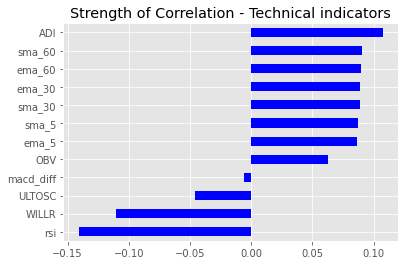

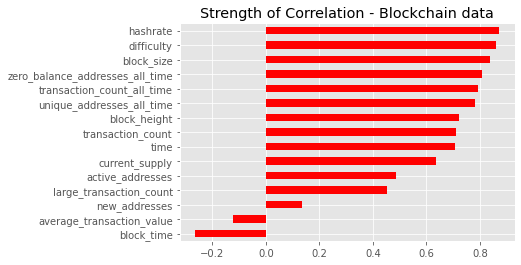

In [29]:
import matplotlib.pyplot as plt

# Correlation strength
plt.style.use('ggplot')

# plt.figure(figsize=(15,10))

corr = features_eth.corrwith(outcomes_eth['close_5'])
corr.sort_values().plot.barh(color = 'blue', title = 'Strength of Correlation - Technical indicators')
plt.show()


plt.style.use('ggplot')
corr = blockchain_data[blockchain_data['symbol'] == 'ETH'].corrwith(ohlcv_data[ohlcv_data['symbol'] == 'ETH']['close'])
corr.sort_values().plot.barh(color = 'red', title = 'Strength of Correlation - Blockchain data')
plt.show()

# Prediction models 

## Technical indicators only

### Simple split

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense


standard_scaler = StandardScaler()

split_point = int(0.80*len(features_eth))

features = features_eth_blockchain.merge(features_eth, on='date')
target = outcomes_eth['direction_5']
# train_dataset = features_eth.join(outcomes_eth['direction_1']).iloc[:split_point,:]

X_train = features.iloc[:split_point, :]
y_train = target.iloc[:split_point]

X_test = features.iloc[split_point:, :] 
y_test = target.iloc[split_point:]

# Transform training dataset
X_train = standard_scaler.fit_transform(X_train)
# y_train = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))

# Transform test dataset
X_test = standard_scaler.fit_transform(X_test)
# y_test = standard_scaler.fit_transform(y_test.values.reshape(-1, 1))

# model = LogisticRegression()
model = svm.SVC(kernel='linear', C=1000)

# model = Sequential()
# model.add(LSTM(256, return_sequences = True, input_shape = (X_train.shape[1], 2)))
# model.add(LSTM(128,input_shape = (X_train.shape[1], 2)))
# model.add(Dense(2))
# model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# # Fitting the model
# history = model.fit(
#     X_train,
#     validation_data=X_test,
#     epochs=150,
#     verbose=1
# )

model.fit(X=X_train, y=y_train)

print('Accuracy in-sample: {}'.format(model.score(X=X_train, y=y_train)))
print('Accuracy out-of-sample: {}'.format(model.score(X=X_test, y=y_test)))
# print('Coefficients: {}'.format(model.coef_))

y_pred = model.predict(X_test)

confusion_matrix(y_true=y_test, y_pred=y_pred)

# plt.style.use('ggplot')
# plt.figure(figsize=(15,7))
# plt.plot(y_test, label='Actual')
# plt.plot(y_pred, label='Predicted')
# plt.legend()
# plt.show()

Accuracy in-sample: 0.6290890790135883
Accuracy out-of-sample: 0.4768611670020121


array([[158, 103],
       [157,  79]], dtype=int64)

### **Sliding window**

In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression


# T is the input data for training the model
# n is the number of days to be predicted using the trained model
T = 60
n = 14
resample_period = '{T}d'.format(T=T)
recalc_dates = features_eth.resample(resample_period).mean().index
minmax_scaler = MinMaxScaler()

for i, date in enumerate(recalc_dates[:-1]):
    # print(i, date)
    # len(len(features_eth.loc[date-pd.Timedelta('{T} days'.format(T=T)):date, :]))
    X_train = features_eth.loc[date: recalc_dates[i+1], :]
    y_train = outcomes_eth['direction_1'].loc[date: recalc_dates[i+1]]
    X_train_scaled = minmax_scaler.fit_transform(X_train)
    
    print(X_train.shape, y_train.shape)

    # model = LogisticRegression()

    # model.fit(X_train_scaled, y_train)

    end_date = date + datetime.timedelta(days=n)
    X_test = features_eth.loc[date:end_date]
    print('X_test shape', X_test.shape)
    print(X_test.index.min(), X_test.index.max())

(61, 12) (61,)
X_test shape (15, 12)
2015-10-05 00:00:00 2015-10-19 00:00:00
(61, 12) (61,)
X_test shape (15, 12)
2015-12-04 00:00:00 2015-12-18 00:00:00
(61, 12) (61,)
X_test shape (15, 12)
2016-02-02 00:00:00 2016-02-16 00:00:00
(61, 12) (61,)
X_test shape (15, 12)
2016-04-02 00:00:00 2016-04-16 00:00:00
(61, 12) (61,)
X_test shape (15, 12)
2016-06-01 00:00:00 2016-06-15 00:00:00
(61, 12) (61,)
X_test shape (15, 12)
2016-07-31 00:00:00 2016-08-14 00:00:00
(61, 12) (61,)
X_test shape (15, 12)
2016-09-29 00:00:00 2016-10-13 00:00:00
(61, 12) (61,)
X_test shape (15, 12)
2016-11-28 00:00:00 2016-12-12 00:00:00
(61, 12) (61,)
X_test shape (15, 12)
2017-01-27 00:00:00 2017-02-10 00:00:00
(61, 12) (61,)
X_test shape (15, 12)
2017-03-28 00:00:00 2017-04-11 00:00:00
(61, 12) (61,)
X_test shape (15, 12)
2017-05-27 00:00:00 2017-06-10 00:00:00
(61, 12) (61,)
X_test shape (15, 12)
2017-07-26 00:00:00 2017-08-09 00:00:00
(61, 12) (61,)
X_test shape (15, 12)
2017-09-24 00:00:00 2017-10-08 00:00:00

In [101]:
features_eth.loc[date-pd.Timedelta('{T} days'.format(T=T)):date, :]

,sma_5,sma_30,sma_60,ema_5,ema_30,ema_60,rsi,macd_diff,OBV,ADI,WILLR,ULTOSC
date,,,,,,,,,,,,
2015-10-05 01:00:00,0.66780,0.881877,1.101105,0.664376,0.885596,1.205748,32.312869,0.008818,-13011189.83,-5.895761e+04,-70.756646,57.471274
2015-10-06 01:00:00,0.66254,0.860360,1.065813,0.661417,0.870751,1.187708,35.039518,0.010952,-12625399.96,2.835914e+05,-63.368669,52.475356
2015-10-07 01:00:00,0.64970,0.839347,1.062547,0.644811,0.854032,1.168819,32.714742,0.010151,-12944667.33,1.262202e+05,-73.710247,46.794519
2015-10-08 01:00:00,0.63648,0.819030,1.060508,0.636708,0.838965,1.150841,33.675485,0.010899,-12470940.76,2.429838e+05,-63.495910,47.321219
2015-10-09 01:00:00,0.63304,0.800427,1.059913,0.640772,0.826703,1.134384,36.777691,0.013797,-11917825.11,7.712624e+04,-48.370319,45.652935
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-30 00:00:00,0.88190,0.925297,0.792053,0.884411,0.892413,0.914372,48.032395,-0.013616,-11669013.52,4.638416e+05,-69.595476,42.032160
2015-12-01 00:00:00,0.87976,0.919360,0.795322,0.880241,0.891090,0.912980,47.749116,-0.012963,-12361688.58,8.590772e+05,-61.804145,47.122200
2015-12-02 00:00:00,0.87126,0.914743,0.797635,0.861960,0.886852,0.910108,43.595747,-0.014972,-12929359.92,7.077980e+05,-77.326969,47.858847


In [103]:
features_eth.index.min(), features_eth.max()

pd.date_range(start=features_eth.index.min(), end = features_eth.max() ).difference(features_eth.index).index


TypeError: Cannot convert input [sma_5        4.713480e+03
sma_30       4.452275e+03
sma_60       4.296683e+03
ema_5        4.676136e+03
ema_30       4.349388e+03
ema_60       4.172271e+03
rsi          9.308666e+01
macd_diff    1.031948e+02
OBV          8.636816e+07
ADI          7.488371e+07
WILLR       -0.000000e+00
ULTOSC       8.242648e+01
dtype: float64] of type <class 'pandas.core.series.Series'> to Timestamp

In [106]:
features_eth.index[0], features_eth.index[-1]

(Timestamp('2015-10-05 01:00:00'), Timestamp('2022-07-23 01:00:00'))

### Expanding and Rolling Window techniques

In [7]:
from run_predictions import fit_expanding_window, predict_expanding_window, fit_rolling_window, predict_rolling_window
from sklearn.linear_model import LinearRegression, LogisticRegression

models_expanding_window = fit_expanding_window(features_eth, outcomes_eth['direction_1'], model_instance=LogisticRegression())
predictions_expanding_window = predict_expanding_window(models_expanding_window, features_eth)

models_rolling_window = fit_rolling_window(features_eth, outcomes_eth['direction_1'], model_instance=LogisticRegression())
predictions_rolling_window = predict_rolling_window(models_rolling_window, features_eth)


Predicting for the period between 2015-10-31 00:00:00 and 2015-11-30 00:00:00

Predicting for the period between 2015-11-30 00:00:00 and 2015-12-31 00:00:00

Predicting for the period between 2015-12-31 00:00:00 and 2016-01-31 00:00:00

Predicting for the period between 2016-01-31 00:00:00 and 2016-02-29 00:00:00

Predicting for the period between 2016-02-29 00:00:00 and 2016-03-31 00:00:00

Predicting for the period between 2016-03-31 00:00:00 and 2016-04-30 00:00:00

Predicting for the period between 2016-04-30 00:00:00 and 2016-05-31 00:00:00

Predicting for the period between 2016-05-31 00:00:00 and 2016-06-30 00:00:00

Predicting for the period between 2016-06-30 00:00:00 and 2016-07-31 00:00:00

Predicting for the period between 2016-07-31 00:00:00 and 2016-08-31 00:00:00

Predicting for the period between 2016-08-31 00:00:00 and 2016-09-30 00:00:00

Predicting for the period between 2016-09-30 00:00:00 and 2016-10-31 00:00:00

Predicting for the period between 2016-10-31 00:00:0

### Expanding window

In [9]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.cluster import hierarchy
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

recalc_dates = features_eth.resample('M').mean().index[:-1]
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
normalizer = Normalizer()

models = pd.Series(index=recalc_dates, dtype='object')

models_expanding_window = pd.Series(index=recalc_dates, dtype='float')

begin_dates = models.index
end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

predictions_expanding_window = pd.Series(index=features_eth.index, dtype='float')

with open('logging_training.log', 'w') as f:

    for date in recalc_dates:
        X_train = features_eth.loc[:date, :]
        y_train = outcomes_eth['direction_1'].loc[:date]
        
        X_train_scaled = minmax_scaler.fit_transform(X_train)
        # y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
        # y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)

        model = LogisticRegression()
        model.fit(X_train_scaled, y_train)

        f.write("Training on the first {} records, from {} to {}\n".
            format(len(y_train), y_train.index.min(), y_train.index.max()))

        models_expanding_window.loc[date] = model


# end_dates = models.index[1:-1]
# end_dates = end_dates.insert(item=features_eth.index[-1], loc=len(end_dates)) 


with open('logging_pred.log', 'w') as f:

    for i, model in enumerate(models_expanding_window): #models_expanding_window.iloc[:-1]
        X = features_eth.loc[begin_dates[i]:end_dates[i]]
        # X_scaled = min_max_scaler.fit_transform(X)
        
        # p = pd.Series(np.concatenate(model.predict(X)), index=X.index, dtype='float')
        p = pd.Series(model.predict(X), index=X.index, dtype='float')

        f.write('Predicting for the period between {begin_dates} and {end_dates}\n'.format(
            begin_dates=begin_dates[i], end_dates=end_dates[i])
            )

        # print('Length of X: {len_x}; \t Length of p: {len_p}'.format(len_x=len(X), len_p=len(p)))
        # print(p)
        # p = pd.Series(model.predict(X), index=X.index)
        predictions_expanding_window.loc[X.index] = p


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\base.py:44

### Rolling window

In [10]:
from sklearn import svm

# recalc_dates = features_eth.resample('M').mean().index[:-1]

# models = pd.Series(index=recalc_dates, dtype='object')

# begin_dates = models.index
# end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

models_rolling_window = pd.Series(index=recalc_dates, dtype='float')

with open('logging.log', 'w') as f:
    for date in recalc_dates:
        X_train = features_eth.loc[date-pd.Timedelta('30 days'):date, :]
        y_train = outcomes_eth['direction_1'].loc[date-pd.Timedelta('30 days'):date]
        
        X_train_scaled = standard_scaler.fit_transform(X_train)
        # y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
        # y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
        
        # model = LogisticRegression()
        model = svm.SVC(kernel='sigmoid', C=1)

        model.fit(X_train_scaled, y_train)
        f.write("Training on the most recent {} records, from {} to {}\n".
            format(len(y_train), y_train.index.min(), y_train.index.max()))

        models_rolling_window.loc[date] = model

    predictions_rolling_window = pd.Series(index=features_eth.index, dtype='float')

    for i, model in enumerate(models_rolling_window):
        X = features_eth.loc[begin_dates[i]:end_dates[i]]
        X_scaled = standard_scaler.fit_transform(X)
        p = pd.Series(model.predict(X_scaled), index=X.index, dtype='float')
        f.write('Predicting for the prediod between {} and {}\n'.format(X.index.min(), X.index.max()))
        # p = pd.Series(np.concatenate(model.predict(X_scaled)), index=X.index, dtype='float')
        predictions_rolling_window.loc[X.index] = p


### Model evaluation

In [11]:
from sklearn.metrics import accuracy_score

common_idx = outcomes_eth['direction_1'].dropna().index.intersection(predictions_expanding_window.dropna().index)
acc_expanding = accuracy_score(y_true = outcomes_eth['direction_1'][common_idx], y_pred=predictions_expanding_window[common_idx])

print("Expanding Window accuracy: {}".format(round(acc_expanding, 3)))

common_idx = outcomes_eth['direction_1'].dropna().index.intersection(predictions_rolling_window.dropna().index)
acc_rolling = accuracy_score(y_true = outcomes_eth['direction_1'][common_idx], y_pred=predictions_rolling_window[common_idx])

print("Rolling Window accuracy: {}".format(round(acc_rolling, 3)))


Expanding Window accuracy: 0.505
Rolling Window accuracy: 0.612


## Blockchain data

### Expanding and Rolling Window techniques

In [20]:
from run_predictions import fit_expanding_window, predict_expanding_window, fit_rolling_window, predict_rolling_window, train_and_predict_expanding
from sklearn.linear_model import LinearRegression, LogisticRegression


predictions_expanding_window = train_and_predict_expanding(features_eth_blockchain, outcomes_eth['direction_1'], LogisticRegression())

# models_expanding_window = fit_expanding_window(features_eth_blockchain, outcomes_eth['direction_1'], model_instance=LogisticRegression(), scaling=False)
# predictions_expanding_window = predict_expanding_window(models_expanding_window, features_eth_blockchain)

# models_rolling_window = fit_rolling_window(features_eth_blockchain, outcomes_eth['direction_1'], model_instance=LogisticRegression())
# predictions_rolling_window = predict_rolling_window(models_rolling_window, features_eth_blockchain)



In [38]:
from sklearn.preprocessing import MinMaxScaler

recalc_dates = features_eth_blockchain.resample('M').mean().index[:-1]

minmax_scaler = MinMaxScaler()

models = pd.Series(index=recalc_dates, dtype='object')
models_expanding_window = pd.Series(index=recalc_dates, dtype='float')

begin_dates = models.index
end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

predictions_expanding_window = pd.Series(index=features_eth_blockchain.index, dtype='float')

for date in recalc_dates:
    X_train = features_eth_blockchain.loc[:date, :]
    y_train = outcomes_eth['direction_1'].loc[:date]
    X_train_scaled = minmax_scaler.fit_transform(X_train)

    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)

    print("Training on the first {} records, from {} to {}\n".
        format(len(y_train), y_train.index.min(), y_train.index.max()))

    models_expanding_window.loc[date] = model


for i, model in enumerate(models_expanding_window): #models_expanding_window.iloc[:-1]
    X = features_eth_blockchain.loc[begin_dates[i]:end_dates[i]]
    X_scaled = minmax_scaler.fit_transform(X)
    # p = pd.Series(np.concatenate(model.predict(X)), index=X.index, dtype='float')
    p = pd.Series(model.predict(X_scaled), index=X.index, dtype='float')

    print('Predicting for the period between {begin_dates} and {end_dates}\n'.format(
        begin_dates=begin_dates[i], end_dates=end_dates[i])
        )

    predictions_expanding_window.loc[X.index] = p

# Rolling window

models_rolling_window = pd.Series(index=recalc_dates, dtype='float')

with open('logging.log', 'w') as f:
    for date in recalc_dates:
        X_train = features_eth_blockchain.loc[date-pd.Timedelta('30 days'):date, :]
        y_train = outcomes_eth['direction_1'].loc[date-pd.Timedelta('30 days'):date]
        
        X_train_scaled = minmax_scaler.fit_transform(X_train)

        model = LogisticRegression()
        # model = svm.SVC(kernel='sigmoid', C=1)

        model.fit(X_train_scaled, y_train)
        f.write("Training on the most recent {} records, from {} to {}\n".
            format(len(y_train), y_train.index.min(), y_train.index.max()))

        models_rolling_window.loc[date] = model

    predictions_rolling_window = pd.Series(index=features_eth_blockchain.index, dtype='float')

    for i, model in enumerate(models_rolling_window):
        X = features_eth_blockchain.loc[begin_dates[i]:end_dates[i]]
        X_scaled = minmax_scaler.fit_transform(X)
        p = pd.Series(model.predict(X_scaled), index=X.index, dtype='float')
        f.write('Predicting for the prediod between {} and {}\n'.format(X.index.min(), X.index.max()))
        # p = pd.Series(np.concatenate(model.predict(X_scaled)), index=X.index, dtype='float')
        predictions_rolling_window.loc[X.index] = p


Training on the first 27 records, from 2015-10-05 01:00:00 to 2015-10-31 00:00:00

Training on the first 57 records, from 2015-10-05 01:00:00 to 2015-11-30 00:00:00

Training on the first 88 records, from 2015-10-05 01:00:00 to 2015-12-31 00:00:00

Training on the first 119 records, from 2015-10-05 01:00:00 to 2016-01-31 00:00:00

Training on the first 148 records, from 2015-10-05 01:00:00 to 2016-02-29 00:00:00

Training on the first 178 records, from 2015-10-05 01:00:00 to 2016-03-30 01:00:00

Training on the first 208 records, from 2015-10-05 01:00:00 to 2016-04-29 01:00:00

Training on the first 239 records, from 2015-10-05 01:00:00 to 2016-05-30 01:00:00

Training on the first 269 records, from 2015-10-05 01:00:00 to 2016-06-29 01:00:00

Training on the first 300 records, from 2015-10-05 01:00:00 to 2016-07-30 01:00:00

Training on the first 331 records, from 2015-10-05 01:00:00 to 2016-08-30 01:00:00

Training on the first 361 records, from 2015-10-05 01:00:00 to 2016-09-29 01:00

In [22]:
recalc_dates = features_eth_blockchain.resample('Q').mean().index[:-1]
recalc_dates


DatetimeIndex(['2015-12-31', '2016-03-31', '2016-06-30', '2016-09-30',
               '2016-12-31', '2017-03-31', '2017-06-30', '2017-09-30',
               '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30',
               '2018-12-31', '2019-03-31', '2019-06-30', '2019-09-30',
               '2019-12-31', '2020-03-31', '2020-06-30', '2020-09-30',
               '2020-12-31', '2021-03-31', '2021-06-30', '2021-09-30',
               '2021-12-31', '2022-03-31', '2022-06-30'],
              dtype='datetime64[ns]', name='date', freq='Q-DEC')

### Model evaluation

In [13]:
from sklearn.metrics import accuracy_score

common_idx = outcomes_eth['direction_1'].dropna().index.intersection(predictions_expanding_window.dropna().index)
acc_expanding = accuracy_score(y_true = outcomes_eth['direction_1'][common_idx], y_pred=predictions_expanding_window[common_idx])
# common_idx = outcomes_eth['direction_1'].dropna().index.intersection(predictions_rolling_window.dropna().index)
acc_rolling = accuracy_score(y_true = outcomes_eth['direction_1'][common_idx], y_pred=predictions_rolling_window[common_idx])

print("Expanding Window accuracy: {}".format(round(acc_expanding, 3)))
print("Rolling Window accuracy: {}".format(round(acc_rolling, 3)))


Expanding Window accuracy: 0.509
Rolling Window accuracy: 0.501
